In [1]:
import cirq, sympy, warnings, tikzplotlib
from scipy.optimize import *
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from io import StringIO

### Cost Matrices

In [2]:
def create_cost_matrix(n_towns):
   """Рандомная матрица с положительными элементами, 
   которая хранит длины рёбер между каждой парой городов"""

   A = np.random.random((n_towns, n_towns))
   
   for i in range(n_towns):
     A[i][i] = np.nan

   return A

In [3]:
def cost_of_permutation(cost_matrix, town_sequence):
  cost = 0.0

  for i in range(len(town_sequence)-1):
    cost += cost_matrix [town_sequence[i]] [town_sequence[i+1]]
  
  return cost

In [4]:
cost_matrix_4 = np.array([[np.nan    , 0.35271991, 0.96262685, 0.11727604],
                          [0.13505078, np.nan    , 0.63915344, 0.43149425],
                          [0.58432224, 0.83676812, np.nan    , 0.4879146 ],
                          [0.14998587, 0.45394107, 0.2140258 , np.nan    ]])

In [5]:
cost_matrix_6 = \
np.array([[    np.nan, 0.00165482, 0.72520661, 0.4163876 , 0.03288493, 0.54206491],
          [0.74621655,     np.nan, 0.37808992, 0.95303594, 0.17005047, 0.61706156],
          [0.01730168, 0.42465019,     np.nan, 0.34035056, 0.9397413 , 0.06493504],
          [0.2761505 , 0.66518233, 0.42480788,     np.nan, 0.11856712, 0.34309329],
          [0.82796128, 0.86227791, 0.29369849, 0.0604712 ,     np.nan, 0.54814749],
          [0.56525883, 0.63791584, 0.29638851, 0.85863453, 0.75516877,     np.nan]])

In [6]:
cost_matrix_8 = np.array([
    [    np.nan, 0.83911204, 0.7035106 , 0.39668363, 0.46117354, 0.19510413, 0.48658963, 0.46131103],
    [0.5870892 ,     np.nan, 0.54862795, 0.74507107, 0.49289714, 0.47200892, 0.57741251, 0.62507757],
    [0.46634288, 0.91587751,     np.nan, 0.35612168, 0.42860855, 0.12815892, 0.89677141, 0.85594071],
    [0.53797555, 0.4979348 , 0.97516805,     np.nan, 0.01425964, 0.21532494, 0.3322861 , 0.0289443 ],
    [0.22634373, 0.62941811, 0.33450535, 0.86398671,     np.nan, 0.50767408, 0.72648152, 0.99268613],
    [0.41810008, 0.98537316, 0.81336165, 0.06436564, 0.58484745,     np.nan, 0.12191475, 0.81467971],
    [0.94842273, 0.44981522, 0.93452495, 0.89825261, 0.36265244, 0.36477084,     np.nan, 0.26013962],
    [0.01901475, 0.50642185, 0.91862145, 0.26389184, 0.29948766, 0.01025452, 0.32753958,     np.nan]])

In [7]:
cost_matrix_10 = np.array([
    [       np.nan, 0.07942641, 0.99031838, 0.09895247, 0.72745531,
        0.81045902, 0.15923533, 0.61330537, 0.90258873, 0.15491793],
       [0.88407753,     np.nan, 0.06199901, 0.56877632, 0.70008972,
        0.81340743, 0.84484164, 0.92044895, 0.59612563, 0.45129374],
       [0.50613502, 0.10989179,     np.nan, 0.73065915, 0.85902533,
        0.27992034, 0.22580289, 0.40041954, 0.66807122, 0.89457109],
       [0.80156922, 0.67934361, 0.44204649,     np.nan, 0.16947546,
        0.29116308, 0.84592144, 0.96306772, 0.98000683, 0.67636839],
       [0.6794687 , 0.15517822, 0.70378366, 0.06865874,     np.nan,
        0.41927295, 0.3731578 , 0.69591233, 0.64424128, 0.04614225],
       [0.05896441, 0.85363734, 0.40025621, 0.13863461, 0.29386601,
            np.nan, 0.60606968, 0.40311522, 0.32417107, 0.3095105 ],
       [0.26764498, 0.99628721, 0.76874766, 0.44323412, 0.34564126,
        0.46406834,     np.nan, 0.18756799, 0.11153533, 0.27771632],
       [0.85918156, 0.4737215 , 0.47637782, 0.47882724, 0.45202033,
        0.40306174, 0.69005201,     np.nan, 0.09939983, 0.05238272],
       [0.4481055 , 0.89202079, 0.18795216, 0.47662974, 0.5363038 ,
        0.00846634, 0.98229673, 0.57620242,     np.nan, 0.80506734],
       [0.38888649, 0.25867673, 0.69360475, 0.56495989, 0.39199138,
        0.27841065, 0.12511922, 0.95978543, 0.44909675,     np.nan]])

### Аналитическое решение

Переберём все перестановки в лексикографическом порядке.

Будем итерироваться по номеру перестановки. Сначала переведём его в факториальную систему счисления [(factoradic)](https://en.wikipedia.org/wiki/Factorial_number_system). Полученные цифры будут совпадать с [кодом Лемера](https://en.wikipedia.org/wiki/Lehmer_code) перестановки. 

Затем по коду Лемера вычислим саму перестановку и затем её стоимость.

In [8]:
# Могут понадобиться факториалы, поэтому на всякий случай вычислим их заранее
#
# factorials[n] == n!

factorials = [1]
for i in range(30):
  # Предполагаю, что n_towns < 30
  factorials.append(factorials[i] * (i+1))

In [9]:
def factoradic_from_perm_number(perm_number : int, factoradic_array):
  """Преобразует число в факториальную систему счисления.
  Записывает полученные цифры в factoradic_array.
  Нулевая цифра в массиве - самая значимая. Последняя цифра всегда равна 0.
  Алгоритм из https://en.wikipedia.org/wiki/Factorial_number_system#Definition """

  N = perm_number
  n_towns = len(factoradic_array)
  assert N < factorials[n_towns]

  for i in range(1, len(factoradic_array) + 1):
    N, factoradic_array[-i] = divmod(N, i)
  
  return factoradic_array

In [10]:
def permutation_from_factoradic(nums : np.ndarray):
  """Перезаписывает массив nums.
  Если изначально там находилось число в факториальной системе, то потом там будет находиться перестановка.
  Города в полученной перестановке нумеруются с 0. 
  Алгоритм из https://en.wikipedia.org/wiki/Lehmer_code#Encoding_and_decoding """
  for i in range(len(nums)-2, -1, -1):
    for j in range(i+1, len(nums)):
      if(nums[j] >= nums[i]):
        nums[j] += 1
  return nums

In [11]:
def analytical(cost_matrix):
  """Перебирает все возможные перестановки и запоминает их кост.
  Возвращает номер наименьшей перестановки и pd.DataFrame со всеми возможными костами"""

  n_towns = len(cost_matrix)

  factoradic_array = np.ndarray(n_towns, int)

  answers_array = []

  min_cost = np.inf
  opt_perm_number = np.nan

  for perm_number in range(factorials[n_towns]):
    town_sequence = permutation_from_factoradic(
                        factoradic_from_perm_number(perm_number, factoradic_array)
                    )
    cost = cost_of_permutation(
        cost_matrix,
        town_sequence
        )

    answers_array.append(cost)

    if cost < min_cost:
      min_cost = cost
      opt_perm_number = perm_number

  return {"opt_perm_number": opt_perm_number,
          "answers_table": pd.DataFrame(answers_array, columns = ["cost"])}

### Алгоритм Rotosolve

In [14]:
def rotosolve(f, x0, tol = 1e-3, max_iter = 150, verbose = False, abs = False):
    """Находит минимум функции f с помощью алгоритма Rotosolve.

    Args:

        x0  - начальная точка, можно взять рандомную

        tol - итерации прекращаются, если улучшение за один цикл обновления вектора X составило меньше tol

        abs - если True, то с величиной tol сравнивается не улучшение f, а его модуль

        max_iter - максимальное число циклов обновления вектора x

        verbose - если True, то сохранять историю значений f

    Returns:

        x, fun - точка минимума и его значение

        num_iterations - число циклов обновления вектора x

        nfev - число вычислений функции, оно равно 3 * len(x0) * num_iterations

        cost_history - Python array
    """

    position = x0
    nfev = 0
    num_iterations = 0
    previous_cost = np.nan
    current_cost = f(x0)
    shifts_history = []

    if verbose:
        cost_history = [current_cost]
    else:
        cost_history = []

    while num_iterations < max_iter:
        if abs:
            if np.abs(previous_cost - current_cost) < tol:
                break
        else:
            if previous_cost - current_cost < tol:
                break
        
        previous_cost = current_cost
        for i, theta in enumerate(position):

            position[i] = theta + np.pi / 2
            cost_p = f(position)

            position[i] = theta - np.pi / 2
            cost_m = f(position)

            atan = np.arctan2(2 * current_cost - cost_p - cost_m,
                              cost_p - cost_m)
            position[i] = theta - np.pi / 2 - atan % (2 * np.pi)

            current_cost = f(position)
            if verbose:
                cost_history.append(current_cost)
                shifts_history.append(- np.pi / 2 - atan % (2 * np.pi))

            nfev += 3
        num_iterations += 1

    return {'fun': current_cost,
       'position': position,
 'num_iterations': num_iterations,
           'nfev': nfev,
   'cost_history': cost_history,
 'shifts_history': shifts_history}


In [ ]:
-np.pi % np

In [34]:
def rotosolve_x(f, x0, tol = 1e-2, max_iter = 150, verbose = False):
    """Находит минимум функции f с помощью алгоритма Rotosolve.

    Args:

        x0  - начальная точка, можно взять рандомную

        tol - итерации прекращаются, если улучшение за один цикл обновления вектора X составило меньше tol

        abs - если True, то с величиной tol сравнивается не улучшение f, а его модуль

        max_iter - максимальное число циклов обновления вектора x

        verbose - если True, то сохранять историю значений f

    Returns:

        x, fun - точка минимума и его значение

        num_iterations - число циклов обновления вектора x

        nfev - число вычислений функции, оно равно 3 * len(x0) * num_iterations

        cost_history - Python array
    """

    position = x0
    nfev = 0
    num_iterations = 0
    max_shift_in_cycle = np.nan
    current_cost = f(x0)
    shifts_history = []

    if verbose:
        cost_history = [current_cost]
    else:
        cost_history = []

    while num_iterations < max_iter and not max_shift_in_cycle < tol:
        
        max_shift_in_cycle = np.nan
        for i, theta in enumerate(position):

            position[i] = theta + np.pi / 2
            cost_p = f(position)

            position[i] = theta - np.pi / 2
            cost_m = f(position)

            atan = np.arctan2(2 * current_cost - cost_p - cost_m,
                              cost_p - cost_m)
            shift = - np.pi / 2 - atan
            position[i] = (theta + shift) % (2 * np.pi)
            shift_ = abs(shift) % (2 * np.pi)

            if not shift_ < max_shift_in_cycle:
                max_shift_in_cycle = shift_

            current_cost = f(position)
            if verbose:
                cost_history.append(current_cost)
                shifts_history.append(shift)

            nfev += 3
        num_iterations += 1

    return {'fun': current_cost,
       'position': position,
 'num_iterations': num_iterations,
           'nfev': nfev,
   'cost_history': cost_history}


In [30]:
coefs = np.random.random(10)
coefs

array([0.40676016, 0.12846866, 0.15928131, 0.00433343, 0.69871923,
       0.78507165, 0.77752863, 0.63152013, 0.9276241 , 0.51193482])

In [29]:
f = lambda x : np.sum(np.sin(x) * coefs)

In [35]:
rotosolve_x(f, 2 * np.pi * np.random.random(10))

{'fun': -5.031242116839393,
 'position': array([4.71238898, 4.71238898, 4.71238898, 4.71238898, 4.71238898,
        4.71238898, 4.71238898, 4.71238898, 4.71238898, 4.71238898]),
 'num_iterations': 2,
 'nfev': 60,
 'cost_history': []}

In [32]:
-np.sum(coefs)

-5.031242116839393

### Базовая схема (только Rx)

In [36]:
class RxCircuit:

   def __init__(self, n_towns):
      n_qubits = int(np.ceil(np.log2(factorials[n_towns])))

      self.qubits = cirq.LineQubit.range(n_qubits)
      self.circuit = cirq.Circuit()
      self.simulator = cirq.Simulator()

      self._town_sequence = np.ndarray(n_towns, int)
      self.n_towns = n_towns

      self._angle_names = [f'a_{i}' for i in range(n_qubits)]
      angle_symbols = sympy.symbols(self._angle_names)
      self._grad = np.ndarray(len(angle_symbols))
      self._hess = np.ndarray((len(angle_symbols), len(angle_symbols)))

    # Параметрические гейты
      rx_gates = [cirq.rx(angle)(qubit)
                  for (angle, qubit)
                  in zip(angle_symbols, self.qubits)]

      self.circuit.append(rx_gates)
      
      measurements = cirq.measure_each(*self.qubits)
      self.circuit.append(cirq.Moment(measurements))


   def measure(self, angles, repetitions = 1):

      params = cirq.ParamResolver({
         name: value for (name, value) in
         zip(self._angle_names, angles)
      })

      return self.simulator.run(self.circuit, params, repetitions)


   def cost_of_bits(self, bits, cost_matrix):
      "Вычисляет по последовательности битов перестановку и её стоимость"
      return cost_of_permutation(
          cost_matrix,
          permutation_from_factoradic(
              factoradic_from_perm_number(
                  cirq.big_endian_bits_to_int(bits) % factorials[self.n_towns],
                  self._town_sequence
              )
          )
      )


   def costs(self, angles, cost_matrix, repetitions):
      "Повторяет измерения и каждый раз вычисляет кост"

      measurementDataFrame = self.measure(angles, repetitions).data

      return measurementDataFrame.apply(
          self.cost_of_bits, 
          axis = 1, raw = True, args = (cost_matrix,)
          )
   
   def cost_derivative(self, angles, cost_matrix, repetitions = 100):
      "Сэмплирует и вычисляет производную в соответствии с Parameter Shift Rule"

      for i, theta in enumerate(angles):

         angles[i] = theta + np.pi / 2
         cost_plus = self.costs(angles, cost_matrix, repetitions).mean()

         angles[i] = theta - np.pi / 2
         cost_minus = self.costs(angles, cost_matrix, repetitions).mean()

         self._grad[i] = (cost_plus - cost_minus) / 2
         angles[i] = theta
      
      return self._grad

   def cost_hess(self, angles, cost_matrix, repetitions = 100):
      for i, theta_i in enumerate(angles):
         for j, theta_j in enumerate(angles[:i+1]):
            angles[i] = theta_i + np.pi / 2
            angles[j] = theta_j + np.pi / 2
            cpp = self.costs(angles, cost_matrix, repetitions).mean()

            angles[j] = theta_j - np.pi / 2
            cpm = self.costs(angles, cost_matrix, repetitions).mean()

            angles[i] = theta_i - np.pi / 2
            cmm = self.costs(angles, cost_matrix, repetitions).mean()

            angles[j] = theta_j + np.pi / 2
            cmp = self.costs(angles, cost_matrix, repetitions).mean()

            self._hess[i][j] = self._hess[j][i] = (cpp - cpm - cmp + cmm) / 4

            angles[i] = theta_i
            angles[j] = theta_j
            
      return self._hess


   def optimize(self, cost_matrix, 
               optimizer = rotosolve,
               repetitions = 100,
               **optimizer_kwargs):
      """
      Вызывает функцию, заданную в аргументе optimizer.
      С её помощью подбирает параметры гейтов так,
      чтобы решить задачу коммивояжёра.
      Маршрут вычисляется на основе результатов измерений снова и снова,
      а затем суммарная длина пути усредняется. 
      Именно эту усреднённую длину пути мы пытаемся минимизировать.

      Args:

       cost_matrix - матрица размером n_towns × n_towns такая, что
                     cost_matrix[i][j] есть длина пути между городами i и j

       optimizer - одна из функций https://docs.scipy.org/doc/scipy/reference/optimize.html#global-optimization

       repetitions - число повторений для усреднения коста. 
                     Для градиентных методов нужна высокая точность, 
                     так как они считают разность между близкими величинами.
                     Могут потребоваться миллионы повторений.
      """

      cost_lambda = lambda angles : self.costs(angles, cost_matrix, repetitions).mean()
      jac_lambda  = lambda angles : self.cost_derivative(angles, cost_matrix, repetitions)
      hess_lambda = lambda angles : self.cost_hess(angles, cost_matrix, repetitions)
      

      if 'jac' in optimizer.__code__.co_varnames:
         optimizer_kwargs['jac'] = jac_lambda

      if 'hess' in optimizer.__code__.co_varnames:
         optimizer_kwargs['hess'] = hess_lambda

      if optimizer == basinhopping or optimizer == minimize or optimizer == rotosolve or optimizer == rotosolve_x:
         if 'x0' not in optimizer_kwargs:
            optimizer_kwargs['x0'] = [2 * np.pi * (np.random.random() - 0.5)
                                    for _ in self._angle_names]
      else:
         if 'bounds' not in optimizer_kwargs:
            if optimizer == shgo:
               optimizer_kwargs['bounds'] = [(None, None) for _ in self._angle_names]
            else:
               optimizer_kwargs['bounds'] = [(-np.pi, np.pi) for _ in self._angle_names]

      return optimizer(cost_lambda, **optimizer_kwargs)


   def __str__(self):
      return self.circuit.__str__()

   def _repr_pretty_(self, *args):
      "Text output in Jupyter"
      return self.circuit._repr_pretty_(*args)

### Другая схема RxCNOT

In [37]:
class RxCNOTCircuit(RxCircuit):
   def __init__(self, n_towns, n_layer_pairs):
      n_qubits = int(np.ceil(np.log2(factorials[n_towns])))

      self.qubits = cirq.LineQubit.range(n_qubits)
      self.circuit = cirq.Circuit()
      self.simulator = cirq.Simulator()

      self._town_sequence = np.ndarray(n_towns, int)
      self.n_towns = n_towns

      self._angle_names = [f'a_{i}' for i in range(n_layer_pairs * n_qubits)]
      angle_symbols = sympy.symbols(self._angle_names)
      self._grad = np.ndarray(len(angle_symbols))
      self._hess = np.ndarray((len(angle_symbols), len(angle_symbols)))

      # Параметрические гейты
      for layer_pair in range(n_layer_pairs):
          rx_gates = [cirq.rx(angle)(qubit)
                      for (angle, qubit)
                      in zip(
                        angle_symbols[layer_pair*n_qubits : (layer_pair+1)*n_qubits],
                        self.qubits) 
                    ]
          self.circuit.append(cirq.Moment(rx_gates))

          cnot_gates = [cirq.CNOT(q1, q2)
                        for (q1, q2)
                        in zip(self.qubits, self.qubits[1:]) ]
          self.circuit.append(cnot_gates)

      # Измерения
      measurements = cirq.measure_each(*self.qubits)
      self.circuit.append(cirq.Moment(measurements))

### Функция тестирования

In [25]:
def extensively_test_circuit(cost_matrix, circuit, optimizer = rotosolve, iterations = 50, repetitions = 100, **optimizer_kwargs):
  res = []

  for _ in range(iterations):
    res_n = circuit.optimize(cost_matrix, optimizer, repetitions, **optimizer_kwargs)
    res.append((res_n['fun'], res_n['nfev'], res_n.get('njev'), res_n.get('nhev')))

  return pd.DataFrame(res, columns = ["cost", "nfev", "njev", "nhev"]).fillna(0)

#### Density Plot для 4 городов c другой матрицей

In [79]:
cost_matrix_4_2 = create_cost_matrix(4)
cost_matrix_4_2

array([[       nan, 0.81622592, 0.20408823, 0.09008185],
       [0.76482761,        nan, 0.14736744, 0.3630235 ],
       [0.61341101, 0.77179601,        nan, 0.95344378],
       [0.55374766, 0.6944981 , 0.16269875,        nan]])

In [80]:
f4 = extensively_test_circuit(cost_matrix_4_2, RxCNOTCircuit(4, 1), abs = False)
f4.mean()

cost     0.926754
nfev    49.500000
njev     0.000000
nhev     0.000000
dtype: float64

In [95]:
f4r = extensively_test_circuit(cost_matrix_4_2, RxCircuit(4), abs = False)
f4r.mean()

cost     0.899262
nfev    50.100000
njev     0.000000
nhev     0.000000
dtype: float64

In [82]:
a4 = extensively_test_circuit(cost_matrix_4_2, RxCNOTCircuit(4, 1), abs = True)
a4.mean()

cost     0.925068
nfev    73.200000
njev     0.000000
nhev     0.000000
dtype: float64

In [96]:
a4r = extensively_test_circuit(cost_matrix_4_2, RxCircuit(4), abs = True)
a4r.mean()

cost     0.893819
nfev    90.900000
njev     0.000000
nhev     0.000000
dtype: float64

In [84]:
x4 = extensively_test_circuit(cost_matrix_4_2, RxCNOTCircuit(4, 1), rotosolve_x, tol = 0.5)
x4.mean()

cost     0.92664
nfev    39.60000
njev     0.00000
nhev     0.00000
dtype: float64

In [91]:
anal4 = analytical(cost_matrix_4_2)

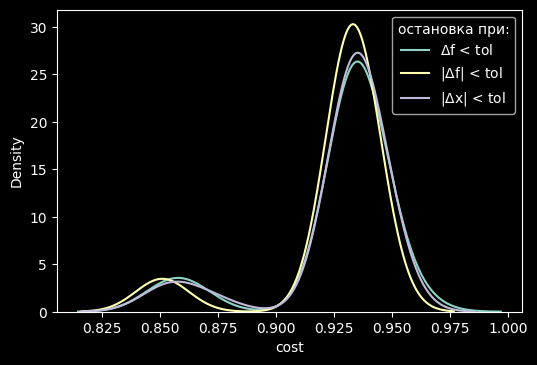

In [86]:
plt.figure(dpi = 100)
sns.kdeplot(f4['cost'], label = '$\Delta$f < tol')
sns.kdeplot(a4['cost'], label = '|$\Delta$f| < tol')
sns.kdeplot(x4['cost'], label = '|$\Delta$x| < tol')
plt.legend(title = "остановка при:")

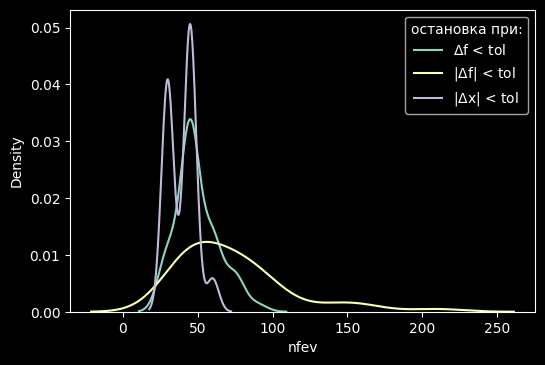

In [87]:
plt.figure(dpi = 100)
sns.kdeplot(f4['nfev'], label = '$\Delta$f < tol')
sns.kdeplot(a4['nfev'], label = '|$\Delta$f| < tol')
sns.kdeplot(x4['nfev'], label = '|$\Delta$x| < tol')
plt.legend(title = "остановка при:")

In [88]:
plt.style.use("default")
sns.set_theme()
sns.set_palette('colorblind')

In [89]:
sns.set_style({"font": "Times New Roman"})

Text(0.5, 1.0, 'Результаты алгоритма в случае 4 городов')

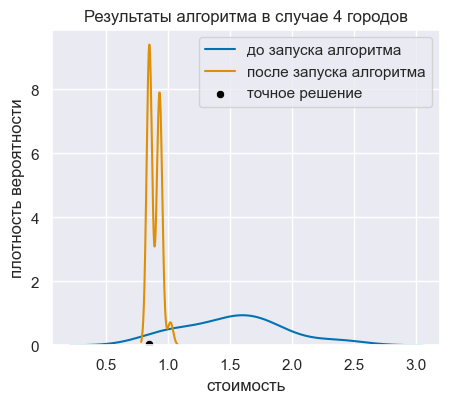

In [99]:
plt.figure(dpi = 100, figsize = (5, 4.1))
ax =\
sns.kdeplot(anal4['answers_table']['cost'] , label = 'до запуска алгоритма')
sns.kdeplot(a4r['cost'] , label = 'после запуска алгоритма')
#sns.kdeplot(a4['cost'] , label = 'после запуска алгоритма')
sns.scatterplot(x = [anal4['answers_table']['cost'][anal4['opt_perm_number']]], y = [0.05], color = "black", label = "точное решение", s = 36)
plt.legend()
ax.set_xlabel("стоимость")
ax.set_ylabel("плотность вероятности")
ax.set_title("Результаты алгоритма в случае 4 городов")
#plt.savefig("../tex/4towns.pdf")

### 6 городов

In [100]:
anal6 = analytical(cost_matrix_6)
anal6['answers_table'].iloc[[anal6['opt_perm_number']]]

,cost
649,0.545867


In [102]:
# 25 sec
f6 = extensively_test_circuit(cost_matrix_6, RxCircuit(6), abs = False)
f6.mean()

cost      1.040104
nfev    121.800000
njev      0.000000
nhev      0.000000
dtype: float64

In [103]:
# 1 m 20 s
a6 = extensively_test_circuit(cost_matrix_6, RxCircuit(6), abs = True)
a6.mean()

cost      0.947968
nfev    347.400000
njev      0.000000
nhev      0.000000
dtype: float64

In [61]:
x6 = extensively_test_circuit(cost_matrix_6, RxCircuit(6), rotosolve_x, tol = 0.3)
x6

,cost,nfev,njev,nhev
0,0.645609,150,0,0
1,1.344563,120,0,0
2,1.144828,60,0,0
3,0.754264,120,0,0
4,0.887305,210,0,0
5,0.718909,120,0,0
6,0.954370,120,0,0
7,0.600535,120,0,0
8,0.877851,90,0,0
9,0.749457,120,0,0


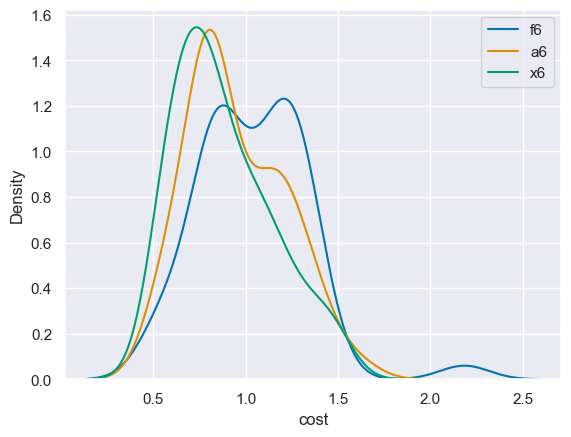

In [107]:
plt.figure(dpi = 100)
sns.kdeplot(f6['cost'], label = 'f6')
sns.kdeplot(a6['cost'], label = 'a6')
sns.kdeplot(x6['cost'], label = 'x6')
plt.legend()

In [104]:
pd.DataFrame([f6.mean(), a6.mean(), x6.mean()], index = ['f6', 'a6', 'x6'])

,cost,nfev,njev,nhev
f6,1.040104,121.8,0.0,0.0
a6,0.947968,347.4,0.0,0.0
x6,0.878949,113.4,0.0,0.0


In [74]:
x6_2 = extensively_test_circuit(cost_matrix_6, RxCNOTCircuit(6, 1), rotosolve_x, tol = 0.2, iterations=100)
x6_2.mean()

cost      0.908444
nfev    146.700000
njev      0.000000
nhev      0.000000
dtype: float64

In [77]:
x6_3 = extensively_test_circuit(cost_matrix_6, RxCNOTCircuit(6, 1), rotosolve_x, tol = 0.2, iterations=100)
x6_3.mean()

cost      0.928418
nfev    174.000000
njev      0.000000
nhev      0.000000
dtype: float64

<AxesSubplot:xlabel='cost', ylabel='Density'>

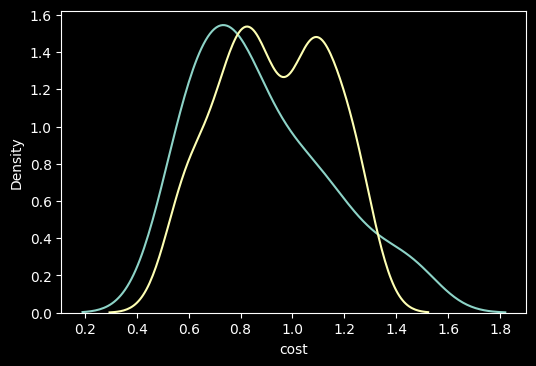

In [78]:
plt.figure(dpi = 100)
sns.kdeplot(x6['cost'])
sns.kdeplot(x6_3['cost'])

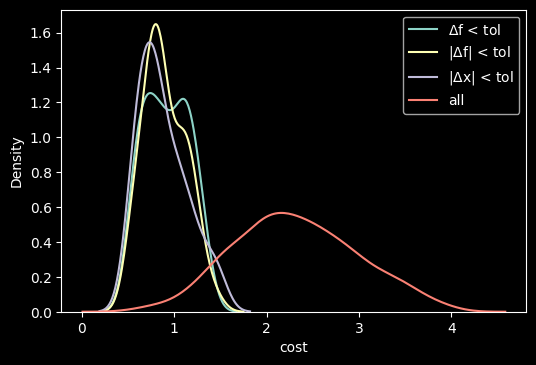

In [76]:
plt.figure(dpi = 100)
sns.kdeplot(f6['cost'], label = '$\Delta$f < tol')
sns.kdeplot(a6['cost'], label = '|$\Delta$f| < tol')
sns.kdeplot(x6['cost'], label = '|$\Delta$x| < tol')
sns.kdeplot(anal6['answers_table']['cost'], label = 'all')
plt.legend()

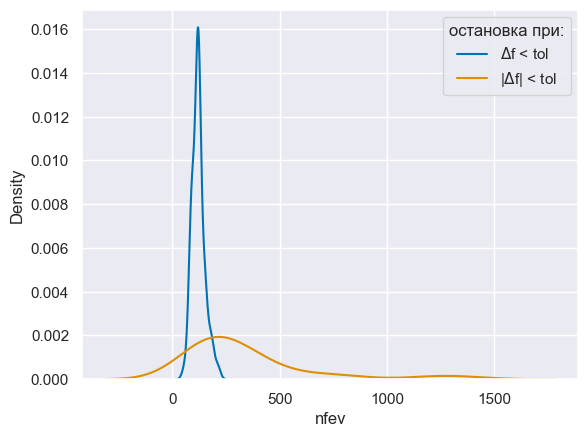

In [125]:
plt.figure(dpi = 100)
sns.kdeplot(f6['nfev'], label = '$\Delta$f < tol')
sns.kdeplot(a6['nfev'], label = '|$\Delta$f| < tol')
plt.legend(title = "остановка при:")

### 8 Городов

In [59]:
anal8 = analytical(cost_matrix_8)
anal8['answers_table'].iloc[[anal8['opt_perm_number']]]

,cost
35577,1.464352


In [50]:
f8 = extensively_test_circuit(cost_matrix_8, RxCNOTCircuit(8, 1))
f8

,cost,nfev,njev,nhev
0,1.787046,288,0,0
1,1.539058,240,0,0
2,2.023303,288,0,0
3,2.071798,240,0,0
4,1.876805,240,0,0
5,2.007658,336,0,0
6,2.196086,288,0,0
7,1.714119,192,0,0
8,2.317960,288,0,0
9,1.701269,240,0,0


### 10 городов

In [64]:
anal10 = analytical(cost_matrix_10)
anal10['answers_table'].iloc[[anal10['opt_perm_number']]]

,cost
1248354,0.836561


In [60]:
# 30 min
f10 = extensively_test_circuit(cost_matrix_10, RxCNOTCircuit(10, 1))
f10

,cost,nfev,njev,nhev
0,2.686780,330,0,0
1,1.505111,330,0,0
2,1.399107,198,0,0
3,2.326404,264,0,0
4,2.846409,264,0,0
5,1.737855,330,0,0
6,2.817570,462,0,0
7,1.650504,528,0,0
8,4.406672,66,0,0
9,2.445617,264,0,0


In [71]:
f10.mean()

cost      2.626095
nfev    315.480000
njev      0.000000
nhev      0.000000
dtype: float64

<AxesSubplot:xlabel='cost', ylabel='Density'>

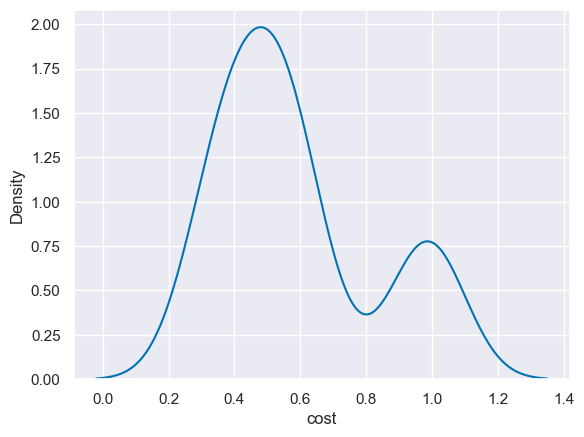

In [74]:
sns.kdeplot(f10['cost'] / anal10['answers_table']['cost'].mean())

In [70]:
better_shares = [
    np.sum(anal4['answers_table']['cost'] < f4['cost'].mean()) / factorials[4],
    np.sum(anal6['answers_table']['cost'] < f6['cost'].mean()) / factorials[6],
    np.sum(anal8['answers_table']['cost'] < f8['cost'].mean()) / factorials[8],
    np.sum(anal10['answers_table']['cost'] < f10['cost'].mean()) / factorials[10],
]
better_shares

[0.041666666666666664,
 0.015277777777777777,
 0.0038442460317460315,
 0.011496638007054675]

In [72]:
1 / np.array(better_shares)

array([ 24.        ,  65.45454545, 260.12903226,  86.98195067])

In [121]:
nfevs = [
    f4['nfev'].mean(),
    f6['nfev'].mean(),
    f8['nfev'].mean(),
    f10['nfev'].mean(),
]
nfevs

[53.4, 123.0, 253.44, 315.48]

### Сводная диаграмма

In [114]:
f4_ = f4[['cost', 'nfev']].copy()
f4_['cost'] /= anal4['answers_table']['cost'].mean()

f6_ = a6[['cost', 'nfev']].copy()
f6_['cost'] /= anal6['answers_table']['cost'].mean()

f8_ = f8[['cost', 'nfev']].copy()
f8_['cost'] /= anal8['answers_table']['cost'].mean()

f10_ = f10[['cost', 'nfev']].copy()
f10_['cost'] /= anal10['answers_table']['cost'].mean()

In [115]:
f_all = pd.concat([f4_, f6_, f8_, f10_], keys = [4, 6, 8, 10], names = ["n_towns"])
f_all

cost  nfev
n_towns                   
4       0   0.347682    45
        1   0.355237    60
        2   0.347682    45
        3   0.347682    45
        4   0.347682    60
...              ...   ...
10      45  0.958244   132
        46  0.936673   132
        47  0.955807   198
        48  0.331382   396
        49  0.501335   330

[200 rows x 2 columns]

In [116]:
anal4_ = anal4['answers_table'] / anal4['answers_table']['cost'].mean()

anal6_ = anal6['answers_table'] / anal6['answers_table']['cost'].mean()

anal8_ = anal8['answers_table'] / anal8['answers_table']['cost'].mean()

anal10_ = anal10['answers_table'] / anal10['answers_table']['cost'].mean()

In [117]:
anal_all = pd.concat([anal4_, anal6_, anal8_, anal10_], keys = [4, 6, 8, 10], names = ["n_towns"])

In [118]:
all_all = pd.concat([f_all, anal_all], keys = ["f", "anal"], names = ["_"])

In [106]:
normalized_best_costs = [
    [4, anal4['answers_table']['cost'][anal4['opt_perm_number']] / anal4['answers_table']['cost'].mean()],
    [6, anal6['answers_table']['cost'][anal6['opt_perm_number']] / anal6['answers_table']['cost'].mean()], 
    [8, anal8['answers_table']['cost'][anal8['opt_perm_number']] / anal8['answers_table']['cost'].mean()],
    [10, anal10['answers_table']['cost'][anal10['opt_perm_number']] / anal10['answers_table']['cost'].mean()]
]
normalized_best_costs

[[4, 0.34768191746048205],
 [6, 0.23556902867347632],
 [8, 0.40551232656449193],
 [10, 0.18612469023670253]]

In [107]:
true_sols = pd.DataFrame(normalized_best_costs, columns = ["n_towns", "normalized_cost"])

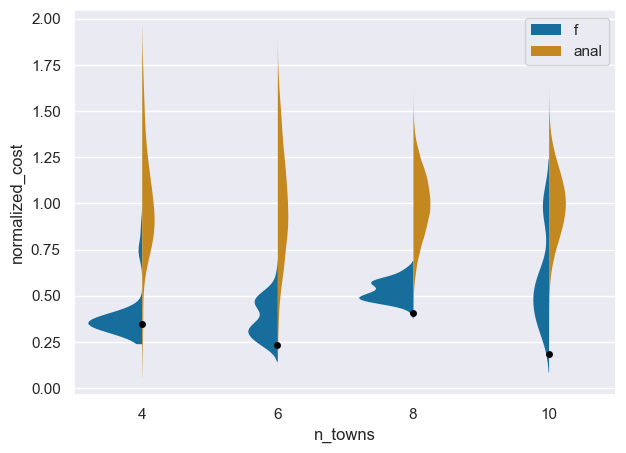

In [119]:
plt.figure(figsize = (7, 5), dpi = 100)
sns.violinplot(data = all_all.reset_index(), 
               x = 'n_towns', y = 'cost', 
               hue = "_", 
               split = True, 
               linewidth = 0,
               #bw = 0.25,
               scale_hue = False,
               #scale = "width"
        )
sns.stripplot(data = true_sols, x = 'n_towns', y = 'normalized_cost', color = 'black', jitter = False)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)
plt.savefig("./violin.png", dpi = 300)